In [1]:
import numpy as np
import cv2
from PIL import Image
import socket
# import shutil
# from skimage import io

class State:
    def __init__(self, state_data):
        self.state_data = np.asarray(state_data)
  
    def process_state(self):
        pass
  
    def get_batch_tensor(self):
        holder = np.asarray(self.state_data)
        holder.reshape((1, ) + holder.shape)
        return holder
  
    def get_individual_tensor(self):
        return np.asarray(self.state_data)

    def get_shape(self):
        return self.state_data.shape
  
    def display(self):
        print(self.state_data)
        
# ------------------------------------

class Frame(State):
    def __init__(self, state_data, crop_factor=None, destination_size=None, vert_cent=0.5):
        State.__init__(self, state_data)
#         self.state_data = self.process_state(crop_factor, vert_cent, destination_shape)
        self.state_data = self.process_state([0.7, 1.0], 0.7, (128,64))
  
    def process_state(self, crop_factor, vert_cent, destination_shape):
        """
        Does all the processing of the frame using the helper functions
        """
        frame = self.crop_frame(self.state_data, crop_factor, vert_cent)
        frame = self.normalise_frame(frame)
        frame = self.gray_scale(frame) # cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        assert len(frame.shape) == 2
        frame = self.downsample_frame(frame, destination_shape)
        return frame

  
    def gray_scale(self, frame, gray_scale_factor=[0.3, 0.3, 0.3]):
        frame = np.dot(frame, np.asarray(gray_scale_factor))
        return frame

    def normalise_frame(self, frame):
        frame = frame.astype('float32') / 255.0
        return frame
  
    def downsample_frame(self, frame, destination_shape):
        """
        downsamples the frame. decreases the resolution
        """
        frame = cv2.resize(np.asarray(frame), dsize=destination_shape, interpolation=cv2.INTER_CUBIC)
        return frame
  
    def crop_frame(self, frame, crop_factor, vert_cent):
        """
        input is the frame
        output is the cropped frame
        crop_factor is the ratio at which you want to crop the height and width(0.8, 0.8)
        cent is the ratio at which the centre of the cropped frame should be
        """
        if crop_factor is None:
          return frame
    
        height_factor = int((crop_factor[0]*frame.shape[0]) // 2)
        width_factor = int((crop_factor[1]*frame.shape[1]) // 2)
        vert_cent = int(frame.shape[0]*vert_cent)
        width_cent = int(frame.shape[1]*0.5)

        frame = frame[vert_cent - height_factor: vert_cent + height_factor, 
                      width_cent - width_factor: width_cent + width_factor]
        return frame

# ------------------------------------
class DataBuffer:
    """
    Keeps track of n latest states 
    """
  
    def __init__(self, size=1):
        self.buffer = []
        self.size = size

    def get_input_tensor(self, in_batch=True):
        arr = np.array(self.buffer)
        if self.size == 1 or in_batch:
            return arr
        else:
            return arr.reshape((1, ) + arr.shape)
    
    def get_input_shape(self):
        return np.asarray(self.current_state[0]).shape

    def assign_to_buffer(self, state):
        if isinstance(state, State):
            state = state.get_individual_tensor()
        if len(self.buffer) >= self.size:
            self.buffer.pop(0)
        self.buffer.append(state)
        
# ------------------------------------

class FrameBuffer(DataBuffer):
    def __init__(self, size = 4):
        DataBuffer.__init__(self, size=size)
    
    def get_input_shape(self):
        return self.get_input_tensor().shape
  
    def get_input_tensor(self, in_batch=True):
        temp = np.array(self.buffer)
        return  temp.transpose((1, 2, 0))
    
    def assign_to_buffer(self, state):
        if isinstance(state, State):
            state = state.get_individual_tensor()
        # if buffer not initialised
        if len(self.buffer) == 0:
            self.buffer = [state]
            return

        if len(self.buffer) >= self.size:
            self.buffer.pop(0)
        
        self.buffer.append(state)

In [2]:
from pathlib import Path
import os
import os.path
import random

class EnvironmentWrapper:
    
    def __init__(self):
        
        
        # initialise comms with the simulator here
        self.sock = socket.socket(socket.AF_INET, socket.SOCK_STREAM) # initialise the socket
        # connect to localhost, port 2345 
        self.sock.bind(("127.0.0.1", 4444))
        self.sock.listen(1)
        print("Waiting to connect to Simulator...")
        self.clientsocket, _ = self.sock.accept() # connect to simulator [BLOCKING]
        print("Connected to simulator!")
        # =========================================
        
        
        # initialising frame buffer
        self.buffer_size = 4 # could change this 
        
         # this is the FrameBuffer that keeps track of the latest frames.
         #initialising the frame buffer by just giving it multiple copies of the same starting frame
        # =========================================
        
        self.current_state = None
        
        self.current_buffer = None
        
        self.prev_dist = 0
        
        self.time_steps = 0
        
        self.done = False
        
        self.max_time_steps_per_episode = 500 #change this based on the enviorment
        
        # initialise buffer
        self.current_buffer = FrameBuffer(size = self.buffer_size)
        
        # =========================================
        
        
        # Create target directory if it doesn't exist
       
        parent_path = os.path.abspath(os.path.join("", os.pardir))
        self.final_path = parent_path + "/simulation/Screenshots"
        if not os.path.exists(self.final_path):
            os.mkdir(self.final_path)
            print("Directory " , self.final_path,  " Created ")
        else:    
            print("Directory " , self.final_path,  " already exists")
            
        
        # Save scr1 to Screenshots if it doesn't already exist
        if not os.path.exists(self.final_path + '/scr1.png'):
            scr1 = Image.open(self.parent_path + '/simulation/scr1.png', 'r')
            scr1.save(self.final_path + "/scr1.png", "PNG")
        
        # reset actually initializes self.current_state, self.current_buffer etc.
        self.reset()
        
        
        
        self.action_space = ['as', 'ar', 'al', 'ds', 'dr', 'dl', 'bs', 'br', 'bl']
        
    
    
    def get_input_shape(self):
        """
        returns the input shape for the input layer of the network
        """
        return self.current_buffer.get_input_shape()
    
#     def get_state_shape(self):
#         """
#         not to be confused with the input shape. This is the shape of individual state (the shape of an individual processed shape of the environment)
#         """
#         return self.current_state
    
    def get_random_action(self):
        """
        returns a random action to be taken. [steering, acceleration, brake]
        """
        return random.choice(self.action_space)
    
    def get_action_at_index(self, index):
        return self.action_space[index]
    
    def get_num_action_space(self):
        """
        returns the number of permuations of valide actions. For Eg. [steer left, accelerate and no brake] is ONE action
        [steer right, accelerate and brake] is invalid as we cannot accelerate and brake at the same time.
        there are 9 possible actions I think?
        """
        return len(self.action_space)
    
    def reset(self):
        """
        resets the environment. self.done denotes whether the episode is done i.e. the car has crashed or we have stopped it
        """
        self.done = False
        self.time_steps = 0
        
        tup = self.step('reset') # initial step. Says don't do anything but send the first 4 frames and game info
        self.current_state, _, self.done = tup
        return self.current_state[0] # send only the frames
        
    
    def step(self, action):
        """ 
        does the action and returns the reward for that action along with the next state

        This function may get complicated as it has to interact with the car simulator throught sockets.
        """
        self.time_steps += 1
        
        if not self.is_done():
            # if the episode has not ended
            #=======================
            
            # send the action
            self.send_message(action)
            
            # wait for results from that action
            angle, distance, speed, self.done, frames_captured = self.get_game_stats() # blocking line
            # print("5: info:{0}, {1}, {2}, {3}, {4}".format(angle, distance, speed, self.done, frames_captured))
            
            
            # add images from path to current_buffer
            for i in range(1, frames_captured + 1):
                # each Frame object is then assigned to the FrameBuffer class in chronological order
                path = self.final_path + '/scr{0}.png'.format(i)
                self.current_buffer.assign_to_buffer(self.get_frame(path))
            
            buffer_tensor = self.current_buffer.get_input_tensor()
            # ========================================
            
            # calculate reward
            dist_delta = self.prev_dist - distance
            self.prev_dist = distance
            if abs(dist_delta) > 10:
                dist_delta = 5 # if there's too big a negative jump in the distance, the car has passed a checkpoint.
                # so, don't penalise it for that.
 
            reward = (dist_delta * 0.9) - (abs(angle) * 0.1)
            #=================
            
            # A buffer is a collection of consecutive frames that we feed to the NN. These frames are already processed.
            
            # the current state consists of all the information from the environment
            self.current_state = (buffer_tensor, angle, distance, speed)
            
            # this returns the state of the environment after the action has been completed, the reward for the action and if the episode ended.
            return self.current_state , reward, self.done
        else:
            return None
    
    def send_message(self, string):
        self.clientsocket.sendall(string.encode())
    
    def receive_message(self):
        data  = self.clientsocket.recv(256).decode()
        return data
    
    
    def is_done(self):
        """
        returns if the episode is finished
        """
        return self.done
        
    
    def get_frame(self, path: str) -> Frame:
        """
        communicates with the sim to get the latest state/frame. 
        returns a Frame object
        Get image from path then convert to np array then make a frame object
        """
        image = Image.open(path, 'r')
        image.load()
        np_data = np.asarray(image, dtype="float32" )
        return Frame(np_data)
    
    
    # def delete_screenshots(self, folder_path: str) -> None:
    #     """
    #     This method deletes the four screenshots saved in folder_path, along with the entire folder.
    #     Method must be called after all four screenshots are converted to Frame objects.
    #     """
    #     shutil.rmtree(folder_path)
    
    
    def get_current_state():
        """
        get the last n frames from the simulator (they might be stored in a folder by the simulator)
        and store them in a buffer and return them
        """
        return self.current_buff

    
    def get_game_stats(self):
        """
        returns a tuple of angle, distance from checkpoint and speed from the sim. Again requires comms with simulator.
        """
        # wait for info to arrive
        string = self.receive_message()
        
        # process string
        value_list = string.split(", ")
        angle = float(value_list[0])
        distance = float(value_list[1])
        speed = float(value_list[2])
        crashed_state = False
        if value_list[3] == '1':
            crashed_state = True
        frames_captured = int(value_list[4])
        # return tuple of values
        return angle, distance, speed, crashed_state, frames_captured
    
    def close(self):
        """
        in case we need to 'close' the environment
        """
        self.sock.close()
        self.clientsocket.close()


In [3]:
class Agent:
    def __init__(self, environment, network, run_only=False, eps_decay_rate=0.9975,max_exp_rate=1.0, min_exp_rate=0.05):
        self.env = environment # this should be the environment wrapper class
        
        if not run_only:
            self.exp_rate = max_exp_rate     # our network starts off with this exploration rate
        else:
            self.exp_rate = 0.0
            self.min_exp_rate = 0.0
        
        self.min_exp_rate = min_exp_rate  # have at least 0.01 exploration rate at all times
        
        self.decay_rate = eps_decay_rate   # decay the exploration rate at this rate
        
        self.time_step = 0     # keeps track of time steps
        
        self.network = network
    
    def take_action(self, current_state):
        # Implement the epsilon greedy strategy 
        result = random.random()                      # get a random number from 0 to 1 with linear distribution
        if result > self.get_exp_rate():              # if it falls over the explore rate, exploit
            # Get the action with the maximum q-value
            action = self.env.get_action_at_index(
                self.network.get_max_q_value_index(current_state, which_net = 'online', batch=False))  # exploit
        else:                                         # if it falls under the explore rate, explore
            action = self.env.get_random_action()          # explore (generate a random action from the environment class)
            
        self.increment_time_step()                    # increment time step as well as update the decay rate
        next_state, reward, done = self.env.step(action)# finally, take the action and record the reward
        
        return current_state, self.env.action_space.index(action), reward, next_state[0], done  # return an experience Tuple
        
    
    def reset_time_steps(self, i=0):
        self.timesteps = i
    
    def increment_time_step(self):
        self.time_step += 1
    
    def update_epsilon(self):
        if self.exp_rate > self.min_exp_rate:
            self.exp_rate = self.exp_rate * self.decay_rate
        else:
            self.exp_rate = self.min_exp_rate
    
    def get_exp_rate(self):
        return self.exp_rate

In [4]:
from keras import layers, models
import tensorflow as tf
from keras.optimizers import Adam, RMSprop
class NetworkTracker:
    
    def __init__(self, environment, source=True, verbose = True, network_name = None): # pass in the environment which has input shape of the frame
        self.network_name = network_name
        if source:
            self.model = models.load_model(self.network_name)
        else:
            self.model = self.define_model(environment)
        
        self.target_model = None
        self.clone_policy()
        
        self.verbose = 0
        if verbose:
            self.verbose = 1
              
    def define_model(self, env):
        
        inp_layer = layers.Input(env.get_input_shape())
        
        conv_1 = layers.Conv2D(filters=10, 
                                kernel_size=(4,4), 
                                activation='relu')(inp_layer) # first layer takes input shape from the environment
        
        maxpool_1 = layers.MaxPool2D((3, 3))(conv_1)
        
        conv_2 = layers.Conv2D(filters=20, kernel_size = (3, 3), strides=2, activation='relu')(maxpool_1)

        maxpool_2 = layers.MaxPool2D(3, 3)(conv_2)
        
        flatten = layers.Flatten()(maxpool_2)
        
        adv_dense_1 = layers.Dense(64, activation = 'relu')(flatten)
        
        adv_out = layers.Dense(env.get_num_action_space(), activation='linear', name = 'advantage') (adv_dense_1)
        
        val_dense_1 = layers.Dense(32, activation = 'relu')(flatten)
        
        val_out = layers.Dense(1, activation='linear', name = 'value') (val_dense_1)
        
        def q_out(x):
            value = x[0]
            advantage = x[1]
            return value + advantage
        
        q_output = layers.Lambda(q_out)([val_out, adv_out])
        
        model = models.Model(inp_layer, q_output, name='dueling_dqn')
        
        model.compile(optimizer=Adam(lr=0.0012), loss='mse')
        return model
    
    def get_q_values(self, states, which_net = 'online', batch = False):
        """
        get q values for specified states.
        INPUTS:
        1. states: the input states
        2. which_net: which net you want the prediction from
        3. batch: true if there are multiple states, false if there is only one state
        """
        if isinstance(states[0], DataBuffer): # if you have a list of buffers, convert them to numpy tensors
            states = np.asarray([i.get_input_tensor(in_batch=True) for i in states])
        
        if (not batch) and (not states.shape[0] == 1):
            states = np.expand_dims(states, axis=0)
        
        output_tensor = None
        
        if which_net == 'online':
            output_tensor = self.model.predict(states) 
        elif which_net == 'target':
            output_tensor = self.target_model.predict(states) 
        
        
        if not batch:
            return output_tensor[0]  # you want to convert the 2 dimensional output to 1 dimension to call argmax
        else:
            return output_tensor
    
    def get_max_q_value_index(self, states, which_net = 'online', batch=False):
        return np.argmax(self.get_q_values(states, which_net=which_net, batch = batch), axis=int(batch))
    
    def fit(self, states_batch, targets_batch):
        """
        Fit the states with the target batch
        """
        self.model.fit(states_batch, targets_batch, verbose=1)
        
    def clone_policy(self):
        """
        Clone the target policy
        """
        self.model.save(self.network_name)
        self.target_model = models.load_model(self.network_name)
                  
    def get_model_summary(self):
        """
        Return a summary of the defined model
        """
        return self.model.summary()
    
    def save_policy(self):
        self.model.save(self.network_name)

Using TensorFlow backend.


In [5]:
import random
import pickle
class Memory:
    def __init__(self, size, save_path, mem_source = None):
        self.save_path = save_path
        self.replay = []
        self.limit = size
        self.exp_count = 0
        if mem_source is not None:
            # pick up memory from the specified progess folder
            with open(mem_source + '/memory.pkl', 'rb') as file:
                self.replay = pickle.load(file)[:self.limit] # limit the list size based on the memory limit you specify
            
            self.exp_count = len(self.replay)
    
    def push(self, experience):
        self.exp_count += 1
        
        if self.exp_count < self.limit:
            self.replay.append(experience)  #append to experiences
        else:
            self.replay[self.exp_count%len(self.replay)] = experience  #wrap around if the memory capacity is reached
        assert len(self.replay) <= self.limit
        
    def is_usable(self, batch_size):
        return len(self.replay) >= batch_size
    
    def reset_replay_memory(self):
        self.exp_count = 0
        self.replay = []
        
    def save_to_disk(self):
        # dump memory in the 
        with open(self.save_path + '/memory.pkl', 'wb') as file:
            pickle.dump(self.replay, file)
        
    def sample(self, batch_size):
        return random.sample(self.replay, batch_size)

In [6]:
def extract_tensors(sample):
    """
    takes a sample of experiences and converts them into individual tensors.
    """
    states = []
    actions = []
    rewards = []
    next_states = []
    done_tensor = []
    for experience in sample:
        states.append(experience[0])
        actions.append(experience[1])
        rewards.append(experience[2])
        next_states.append(experience[3])
        done_tensor.append(experience[4])
    
    return np.asarray(states), np.asarray(actions), np.asarray(rewards), np.asarray(next_states), np.asarray(done_tensor)

In [7]:
def get_target_batch(states, actions, rewards, next_states, dones, net, gamma):
    assert actions.ndim == 1
    assert rewards.ndim == 1
    assert dones.ndim == 1
    assert len(actions) == len(rewards) == len(dones) == len(states) == len(next_states)
    
    target_q_values = net.get_q_values(states, which_net = 'online', batch = True) # get the q values from the current states
    
    which_acts = net.get_max_q_value_index(next_states, which_net= 'online', batch = True) # this gives you a list of action indices
    
    q_estimates = net.get_q_values(next_states, which_net = 'target', batch = True) # get the q estimates from the target net for the next states
    
    for index in range(len(target_q_values)):
        # index indexes the batch axis
        q_estimate = q_estimates[index]
        decoupled_action = which_acts[index]
        reward = rewards[index]
        action_taken = actions[index]
        ended = dones[index]
        
        # bellman equation related target value calculation for DDQNs
        if not ended:
            prev_target = q_estimate[decoupled_action]
        else:
            prev_target = 0
        
        target = reward + gamma * prev_target
        
        target_q_values[index][action_taken] = target # assign the target to the corresponding (state, action) pair

    return target_q_values

In [8]:
import matplotlib.pyplot as plt
import os
from tempfile import TemporaryFile
quit = False
import pickle 
def train_agent(contd=True, network_name = None, save_path = 'training_progress', contd_path = None, verbose=True, num_episodes=1500,
                discount = 0.95, batch_size = 64, N = 40, memory_size = 1024, 
                eps_decay_rate=0.9975, max_exp_rate=1.0, min_exp_rate=0.05, max_reward = 1000 ):
    # get all the hyperparameters in one place!
            
     
    # initialise your environment
    env = EnvironmentWrapper()
    
    # initialise your policy and target networks inside net
    net = NetworkTracker(env, source=contd, verbose=verbose, network_name=network_name)
    print(net.get_model_summary())
    
    # initialise your agent that will follow the epsilon greedy strategy
    agent = Agent(env, net, eps_decay_rate=eps_decay_rate, max_exp_rate=max_exp_rate,min_exp_rate=min_exp_rate )    
    
    # initialise experience replay memory
    memory = Memory(memory_size, save_path = save_path, mem_source = contd_path)
    
    # stores all the total reward per episode
    
    training_stats = []
    epochs = []
    starting_episode = 0
    
    sum_over_ten = 0
    moving_avg = []
    avg_epochs = []
    
    validations = []
    validation_epochs = []
    if contd:
        with open(save_path + '/training_stats.pkl', 'rb') as file:
            epochs, training_stats = pickle.load(file)
#             counter_temp = 0
#             temp_sum = 0
#             t = 0
#             for stat in training_stats:
#                 t += 1
#                 counter_temp += 1
#                 temp_sum += stat
#                 if counter_temp%10 == 0:
#                     counter_temp = 0
#                     avg = temp_sum / 10.0
#                     moving_avg.append(avg)
#                     avg_epochs.append(t)
#                     temp_sum = 0
        
        with open(save_path + '/moving_average.pkl', 'rb') as file:
            avg_epochs, moving_avg = pickle.load(file)          
        
        with open(save_path + '/episode_count.pkl', 'rb') as file:
            starting_episode = pickle.load(file)
            
    # graph display init code
    %matplotlib notebook
    plt.rcParams['animation.html'] = 'jshtml'
    fig = plt.figure()
    subplot = fig.add_subplot(111)
    
    for episode_count in range(starting_episode, num_episodes):
        # uncomment if you want to start the environmet with a random move
        # state = env.step(env.get_random_action())[0]
        valid_episode = False
        
        
        # check if the environment is available to run
        while not valid_episode:
            # keeps track of how many steps has been since the reward hasn't moved
            stuck_counter = 0

            # keeps track of the total reward that we got for this episode
            cumulative_reward = 0

            # keeps track of steps in the episode.
            counter = 0

            # reset environement and record the initial state before every episode
            state = env.reset()

            # store the experiences in a temporary tuple so that we only add them to memory if it was a valid episode.
            temp_exp = []
            stuck = False
            # ==============================
            while not env.is_done() and not stuck and cumulative_reward < max_reward: # run the environment for one episode
                counter += 1
                current_state, action, reward, next_state, done = agent.take_action(state) # let the agent take an action for one time step
                
                cumulative_reward += reward # add the reward to total rewards.
                
                # check if the car is stuck when the reward isn't changing by much
                if abs(reward) < 0.5:
                    stuck_counter += 1
                    if stuck_counter > 7:
                        done = True
                        stuck = True
                else:
                    stuck_counter = 0
                experience = current_state, action, reward, next_state, done # experience tuple 
                state = next_state # update the current state
                 # push the experience in memory
                temp_exp.append(experience)
            # ==============================
            
            if counter > 5:
                valid_episode = True
                for i in range(len(temp_exp)):
                    # temp_exp[i][-1] = cumulative_reward
                    memory.push(temp_exp[i])
                sum_over_ten += cumulative_reward

        agent.update_epsilon() # update the exploration rate of the agent after each episode

        if memory.is_usable(batch_size):
                experience_batch = memory.sample(batch_size) # sample randomly from memory
                states, actions, rewards, next_states, done_tensor = extract_tensors(experience_batch) # unzips the tensors

                target_batch = get_target_batch(states, actions, rewards, next_states, done_tensor, net, discount) # get a batch of target values to fit against

                net.fit(states, target_batch) # fit the network

        # append the training stats
        training_stats.append(cumulative_reward)
        epochs.append(episode_count)

        # clone the target policy every N episodes.
        if (episode_count + 1) % N == 0:
            net.clone_policy()
        
        if  (episode_count) % (N*2) == 0:
            performance = evaluate_agent(runs = 5, model_name = network_name, env = env)
            validations.append(performance)
            validation_epochs.append(epochs[-1])
            with open(save_path + '/validation.pkl', 'wb') as file:
                pickle.dump((validation_epochs, validations), file)
            

        # update the training chart every 10 episodes
        if (episode_count + 1) % 10 == 0:
            avg = sum_over_ten / 10.0
            sum_over_ten = 0
            moving_avg.append(avg)
            avg_epochs.append(epochs[-1])
            subplot.plot(epochs, training_stats, color='b')
            subplot.plot(avg_epochs, moving_avg, color = 'r')
            subplot.plot(validation_epochs, validations, color = 'g')
            fig.canvas.draw()
            
            # periodically save training progress.
            memory.save_to_disk()
            with open(save_path + '/training_stats.pkl', 'wb') as file:
                pickle.dump((epochs, training_stats), file)
            
            with open(save_path + '/moving_average.pkl', 'wb') as file:
                pickle.dump((avg_epochs, moving_avg), file)
            
            with open(save_path + '/episode_count.pkl', 'wb') as file:
                pickle.dump(episode_count, file)
            
            with open(save_path + '/epsilon.pkl', 'wb') as file:
                pickle.dump(agent.exp_rate, file)
            

        # if specified, print stats.
        if verbose:
            print("Episode Count: ", episode_count, "\t Cumulative Reward: ", round(cumulative_reward, 2), "\t eps: ", round(agent.exp_rate, 3) )

    
    memory.save_to_disk()
    net.save_policy()
    env.close()
    
    return epochs, training_stats, net





In [9]:
def evaluate_agent(runs, model_name, env = None):
    if env is None:
        env = EnvironmentWrapper()
    net = NetworkTracker(env, source=True, verbose=False, network_name=model_name)
    agent = Agent(env, net, run_only = True)
    
    perf_sum = 0
    for run in range(runs):
        valid_episode = False
        cumulative_reward = 0
        time_steps = 0
        while not valid_episode:
            state = env.reset()
            cumulative_reward = 0
            time_steps = 0
            stuck_counter = 0
            stuck = False
            while not env.is_done() and not stuck:
                _ , action, reward, next_state, done = agent.take_action(state)
                state = next_state
                time_steps += 1
                cumulative_reward += reward 
                if abs(reward) < 0.5:
                    stuck_counter += 1
                    if stuck_counter > 7:
                        done = True
                        stuck = True
                else:
                    stuck_counter = 0
            
            if time_steps > 3:
                valid_episode = True
                cumulative_reward = round(cumulative_reward, 2)
        perf_sum += cumulative_reward
        print('run {0}: cumulative_reward: {1}, ran for: {2} timesteps'.format(run, round(cumulative_reward, 2), time_steps))
    
    avg_perf = float(perf_sum/runs)
    
    print('average performance: ', avg_perf)
#     env.close()
    return avg_perf
    
    

Waiting to connect to Simulator...
Connected to simulator!
Directory  /Users/manavshah/GitHub/SelfDrivingResearch/simulation/Screenshots  already exists
Model: "dueling_dqn"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 64, 128, 4)   0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 61, 125, 10)  650         input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 20, 41, 10)   0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (N

<IPython.core.display.Javascript object>


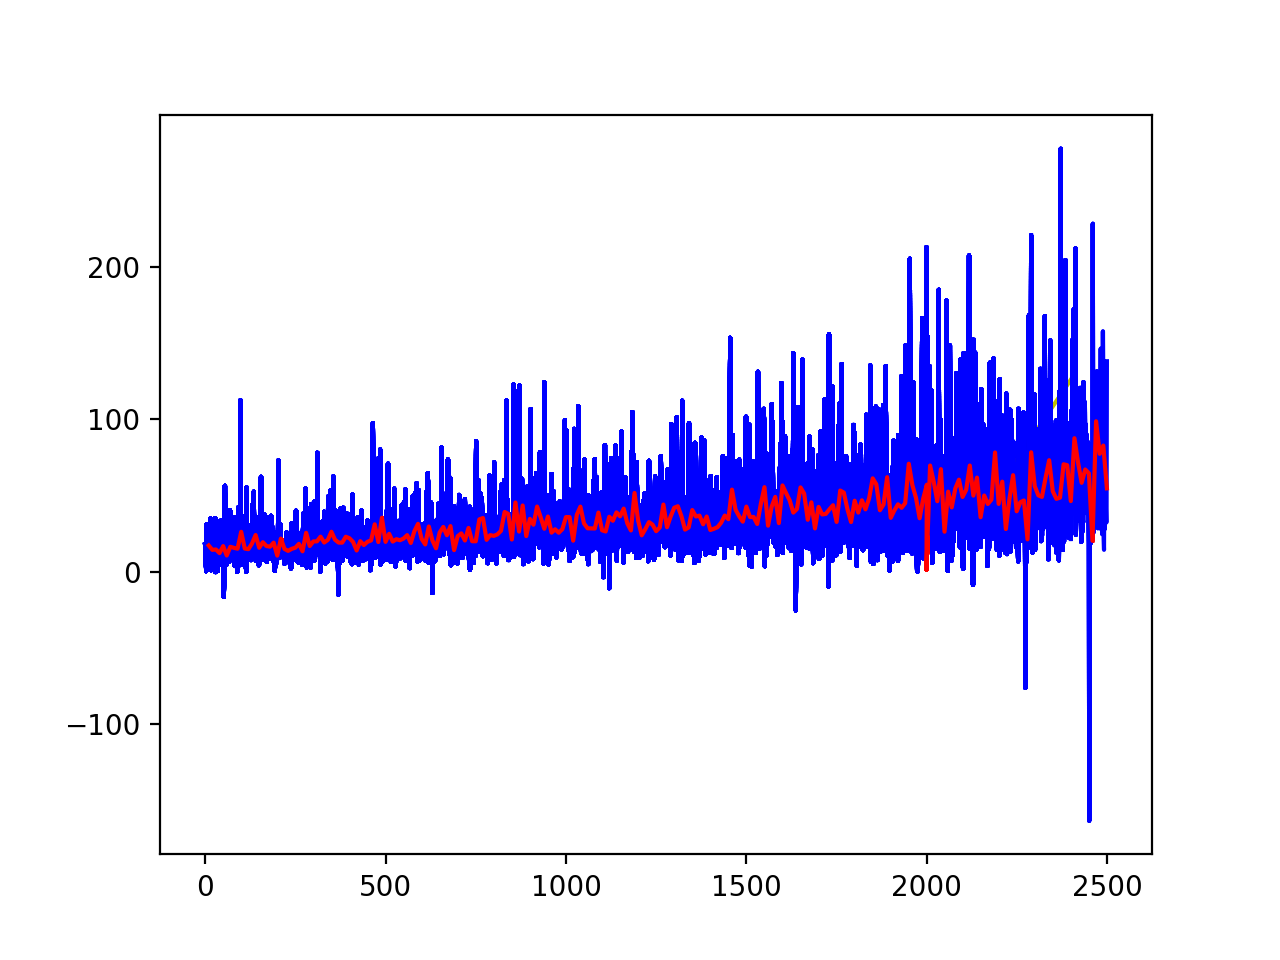

Epoch 1/1
512/512 [==============================] - 4s 7ms/step - loss: 5.1274
Episode Count:  1999 	 Cumulative Reward:  26.17 	 eps:  0.25
Epoch 1/1
512/512 [==============================] - 3s 6ms/step - loss: 4.7908
run 0: cumulative_reward: 43.25, ran for: 27 timesteps
run 1: cumulative_reward: 207.27, ran for: 82 timesteps
run 2: cumulative_reward: 18.4, ran for: 29 timesteps
run 3: cumulative_reward: 9.33, ran for: 6 timesteps
run 4: cumulative_reward: 34.2, ran for: 10 timesteps
average performance:  62.489999999999995
Episode Count:  2000 	 Cumulative Reward:  33.34 	 eps:  0.25
Epoch 1/1
512/512 [==============================] - 3s 6ms/step - loss: 4.4012
Episode Count:  2001 	 Cumulative Reward:  154.73 	 eps:  0.249
Epoch 1/1
512/512 [==============================] - 3s 6ms/step - loss: 5.2635
Episode Count:  2002 	 Cumulative Reward:  28.9 	 eps:  0.249
Epoch 1/1
512/512 [==============================] - 3s 6ms/step - loss: 4.8900
Episode Count:  2003 	 Cumulative Rew

512/512 [==============================] - 3s 5ms/step - loss: 5.6902
Episode Count:  2111 	 Cumulative Reward:  29.67 	 eps:  0.223
Epoch 1/1
512/512 [==============================] - 3s 5ms/step - loss: 4.8705
Episode Count:  2112 	 Cumulative Reward:  53.66 	 eps:  0.223
Epoch 1/1
512/512 [==============================] - 3s 5ms/step - loss: 4.3692
Episode Count:  2113 	 Cumulative Reward:  61.83 	 eps:  0.223
Epoch 1/1
512/512 [==============================] - 3s 5ms/step - loss: 4.9268
Episode Count:  2114 	 Cumulative Reward:  79.18 	 eps:  0.223
Epoch 1/1
512/512 [==============================] - 3s 5ms/step - loss: 4.3764
Episode Count:  2115 	 Cumulative Reward:  131.17 	 eps:  0.222
Epoch 1/1
512/512 [==============================] - 3s 5ms/step - loss: 4.8262
Episode Count:  2116 	 Cumulative Reward:  52.04 	 eps:  0.222
Epoch 1/1
512/512 [==============================] - 3s 5ms/step - loss: 4.9279
Episode Count:  2117 	 Cumulative Reward:  207.48 	 eps:  0.222
Epoch 1

512/512 [==============================] - 3s 5ms/step - loss: 4.9794
Episode Count:  2223 	 Cumulative Reward:  19.52 	 eps:  0.2
Epoch 1/1
512/512 [==============================] - 3s 5ms/step - loss: 5.2422
Episode Count:  2224 	 Cumulative Reward:  29.64 	 eps:  0.199
Epoch 1/1
512/512 [==============================] - 3s 5ms/step - loss: 5.4122
Episode Count:  2225 	 Cumulative Reward:  37.27 	 eps:  0.199
Epoch 1/1
512/512 [==============================] - 3s 5ms/step - loss: 4.7542
Episode Count:  2226 	 Cumulative Reward:  24.32 	 eps:  0.199
Epoch 1/1
512/512 [==============================] - 3s 5ms/step - loss: 5.9315
Episode Count:  2227 	 Cumulative Reward:  31.95 	 eps:  0.199
Epoch 1/1
512/512 [==============================] - 3s 5ms/step - loss: 4.6306
Episode Count:  2228 	 Cumulative Reward:  40.85 	 eps:  0.199
Epoch 1/1
512/512 [==============================] - 3s 5ms/step - loss: 4.9966
Episode Count:  2229 	 Cumulative Reward:  69.48 	 eps:  0.198
Epoch 1/1
5

512/512 [==============================] - 3s 5ms/step - loss: 4.5738
Episode Count:  2337 	 Cumulative Reward:  8.07 	 eps:  0.178
Epoch 1/1
512/512 [==============================] - 3s 5ms/step - loss: 4.4210
Episode Count:  2338 	 Cumulative Reward:  27.56 	 eps:  0.178
Epoch 1/1
512/512 [==============================] - 3s 5ms/step - loss: 4.3244
Episode Count:  2339 	 Cumulative Reward:  75.41 	 eps:  0.178
Epoch 1/1
512/512 [==============================] - 3s 5ms/step - loss: 4.2054
Episode Count:  2340 	 Cumulative Reward:  61.04 	 eps:  0.178
Epoch 1/1
512/512 [==============================] - 3s 5ms/step - loss: 4.0803
Episode Count:  2341 	 Cumulative Reward:  32.11 	 eps:  0.177
Epoch 1/1
512/512 [==============================] - 3s 5ms/step - loss: 4.0530
Episode Count:  2342 	 Cumulative Reward:  151.74 	 eps:  0.177
Epoch 1/1
512/512 [==============================] - 3s 5ms/step - loss: 4.5574
Episode Count:  2343 	 Cumulative Reward:  31.6 	 eps:  0.177
Epoch 1/1


512/512 [==============================] - 3s 5ms/step - loss: 4.9801
Episode Count:  2449 	 Cumulative Reward:  21.13 	 eps:  0.159
Epoch 1/1
512/512 [==============================] - 3s 5ms/step - loss: 5.3750
Episode Count:  2450 	 Cumulative Reward:  -163.65 	 eps:  0.159
Epoch 1/1
512/512 [==============================] - 3s 5ms/step - loss: 5.0045
Episode Count:  2451 	 Cumulative Reward:  25.24 	 eps:  0.159
Epoch 1/1
512/512 [==============================] - 3s 5ms/step - loss: 4.4720
Episode Count:  2452 	 Cumulative Reward:  25.69 	 eps:  0.159
Epoch 1/1
512/512 [==============================] - 3s 5ms/step - loss: 4.3838
Episode Count:  2453 	 Cumulative Reward:  50.5 	 eps:  0.159
Epoch 1/1
512/512 [==============================] - 3s 5ms/step - loss: 4.3591
Episode Count:  2454 	 Cumulative Reward:  18.47 	 eps:  0.158
Epoch 1/1
512/512 [==============================] - 3s 5ms/step - loss: 4.6991
Episode Count:  2455 	 Cumulative Reward:  78.76 	 eps:  0.158
Epoch 1/

In [10]:
history = train_agent(contd = False,
            verbose = True, 
            save_path = 'training_progress',
            contd_path = None, 
            network_name = 'DuelingDdqn.h5',
            num_episodes = 2500,
            discount = 0.99, 
            batch_size = 512, 
            N = 100, # how often to clone the target policy
            memory_size = 4096,
            eps_decay_rate = 0.999,
            max_exp_rate = 0.25, 
            min_exp_rate = 0.1,
            max_reward = 2000)

In [11]:
# evaluate_agent(runs = 10, model_name = 'DuelingDdqn.h5', env = None)